# Attention-based MIL demo.

In [1]:
from torch_tools import ShapesDataset
from torch.utils.data import DataLoader

from torch import zeros, rand, no_grad

from torchvision.transforms import Compose, RandomGrayscale, RandomRotation, Normalize

img_size = 256
patch_size = 64

print(f"Bag size = {(img_size // patch_size) ** 2}")

data_set = ShapesDataset(
    spot_prob=1.0,
    square_prob=1.0,
    octagon_prob=1.0,
    star_prob=0.5,
    target_tfms=Compose([lambda x: x[1]]),
    image_size=img_size,
    num_shapes=3,
)

data_loader = DataLoader(
    data_set,
    shuffle=False,
    batch_size=1,
    drop_last=True,
)

Bag size = 16


In [2]:
import torch
from torch.nn import Module, Linear, Sequential, Tanh
from torch.nn import BatchNorm2d, InstanceNorm2d
from torch.optim import Adam

from torch.cuda import is_available

from torch_tools import ConvNet2d, FCNet, SimpleConvNet2d, Encoder2d
from torch_tools.weight_init import normal_init


DEVICE = "cuda" if is_available() else "cpu"


class AttentionNet(Module):
    """Attention model."""

    def __init__(self):
        """Build attention model."""
        super().__init__()

        # self.encoder = Encoder2d(3, 16, 6, "avg", 0.1, 3)

        self.latent = 128
        self.D = 128

        # self.feats = Linear(2 * 2 * 512, self.latent)

        # self.encoder = SimpleConvNet2d(
        #     in_chans=3,
        #     out_feats=self.latent,
        #     features_start=32,
        # )

        self.encoder = ConvNet2d(
            self.latent,
            encoder_style="resnet18",
            pretrained=True,
        )

        self.attention = Linear(self.latent, 1)

        # self.attention = Sequential(
        #     Linear(self.latent, self.D),
        #     Tanh(),
        #     Linear(self.D, 1),
        # )

        self.classifier = FCNet(self.latent, 1)

    def forward(self, batch):
        """Pass ``batch`` through the model."""
        latent = self.encoder(batch).relu()

        # latent = latent.reshape(len(batch), 2 * 2 * 512)
        # latent = self.feats(latent).relu()

        attention = self.attention(latent).transpose(1, 0)
        attention = attention.softmax(dim=1)
        matrix = torch.mm(attention, latent)

        classification = self.classifier(matrix).sigmoid()

        return classification, attention


def inorm(x):

    for name, layer in x.named_children():

        if isinstance(layer, BatchNorm2d):
            setattr(x, name, InstanceNorm2d(layer.num_features))


model = AttentionNet().to(DEVICE)

model.apply(inorm)


print(model)

AttentionNet(
  (encoder): ConvNet2d(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): In

## Weird hack

In order for the model to behave in a stable fashion, and not have widly divergent behaviour between training and evaluation model, it seems we must set the batchnorms to always use incoming statistics, and stop them from tracking running statistics.

In [3]:
def disable_running_stats(model):
    if isinstance(model, BatchNorm2d):
        model.track_running_stats = False
        model.running_mean = None
        model.running_var = None


model.apply(disable_running_stats)


optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [4]:
from typing import Optional, Dict

from torch import set_grad_enabled
from torch.nn.functional import binary_cross_entropy as bce
from torch import rand
from torch.nn.functional import normalize

from numpy import mean

from torch_tools.torch_utils import patchify_img_batch


def one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Optional[Adam] = None,
):
    """Train or validate the model for a single epoch.

    Parameters
    ----------
    model : Module
        Classifier model.
    data_loader : DataLoader
        Image-yielding data loader.
    optimiser : Adam, optional
        The optimiser to fit the model with.

    """
    metrics = {"loss": [], "accuracy": []}

    if optimiser is not None:
        model.train()
    else:
        model.eval()

    with set_grad_enabled(optimiser is not None):
        for image, target in data_loader:
            if optimiser is not None:
                optimiser.zero_grad()

            image, target = image.to(DEVICE), target.to(DEVICE)

            target = target.reshape(1, 1)

            bag = patchify_img_batch(image, patch_size)

            pred, atten = model(bag)

            loss = bce(pred, target)

            metrics["loss"].append(loss.item())
            metrics["accuracy"].append((pred.item() >= 0.5) == target.item())

            if optimiser is not None:
                loss.backward()
                optimiser.step()

    return {key: mean(val) for key, val in metrics.items()}

In [5]:
from time import perf_counter

epochs = 10

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_metrics.append(one_epoch(model, data_loader, optimiser))
    valid_metrics.append(one_epoch(model, data_loader))

    stop_time = perf_counter()

    print(f"Epoch {epoch + 1} time = {stop_time - start_time:.6f} seconds")

Epoch 1 time = 12.886087 seconds
Epoch 2 time = 12.364115 seconds
Epoch 3 time = 12.121915 seconds
Epoch 4 time = 12.103982 seconds
Epoch 5 time = 12.202123 seconds
Epoch 6 time = 12.581111 seconds
Epoch 7 time = 14.307543 seconds
Epoch 8 time = 14.409866 seconds
Epoch 9 time = 14.322094 seconds
Epoch 10 time = 14.516372 seconds


   loss_train  accuracy_train  loss_valid  accuracy_valid  epoch
0    0.598663           0.669    0.407131           0.808      1
1    0.155272           0.948    0.040773           0.988      2
2    0.068198           0.976    0.023193           0.991      3
3    0.089103           0.971    0.468471           0.794      4
4    0.070195           0.976    0.066187           0.983      5
5    0.035306           0.992    0.040851           0.988      6
6    0.058083           0.987    0.070564           0.980      7
7    0.052747           0.983    0.024494           0.992      8
8    0.054051           0.983    0.038088           0.992      9
9    0.027756           0.992    0.022977           0.994     10


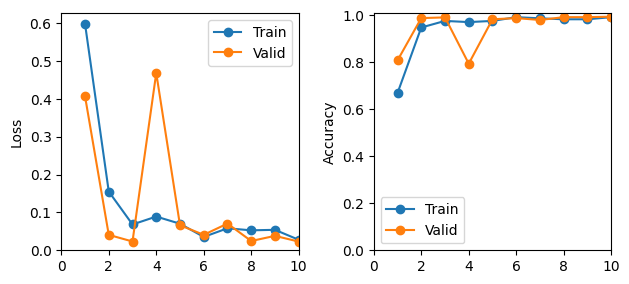

In [6]:
import matplotlib.pyplot as plt
from pandas import DataFrame

from numpy import arange, diff


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)
metrics["epoch"] = arange(1, len(metrics) + 1, 1)

print(metrics)


figure, axes = plt.subplots(1, 2)


for axis, metric in zip(axes.ravel(), ["loss", "accuracy"]):
    for split in ["train", "valid"]:
        axis.plot(
            metrics.epoch,
            metrics[f"{metric}_{split}"],
            "-o",
            label=split.capitalize(),
        )

    axis.set_ylabel(metric.capitalize())



for axis in axes.ravel():

    axis.legend()
    axis.set_xlim(left=0, right=epochs)
    axis.set_ylim(bottom=0.0)
    axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))


figure.tight_layout()

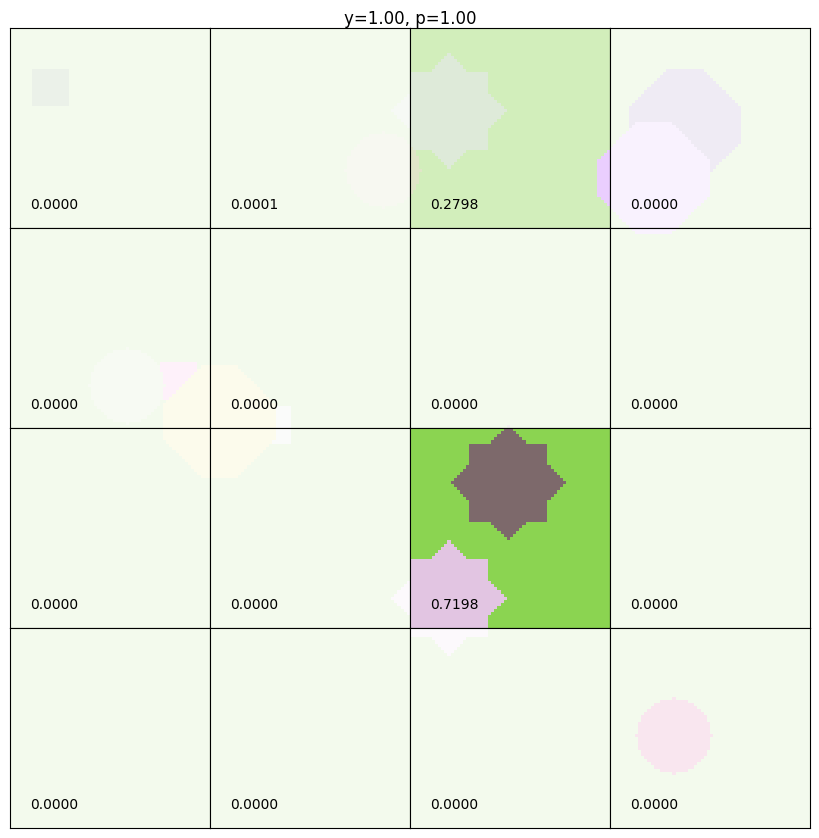

In [7]:
model.eval()

with no_grad():
    for image, target in data_loader:
        image = patchify_img_batch(image, patch_size)
        pred, attention = model(image.to(DEVICE))

        if target.item() == 1.0:
            break

attention = attention.cpu().detach().flatten()


alphas = (attention / attention.max()).clip(0.1, 1.0)


patch_length = img_size // patch_size


figure, axes = plt.subplots(patch_length, patch_length, figsize=(8, 8.2))

for patch, axis, att, alpha in zip(image, axes.ravel(), attention, alphas):
    patch = patch.permute(1, 2, 0).numpy()

    axis.imshow(patch, alpha=alpha.item())
    axis.text(0.1, 0.1, f"{att.item():.4f}", transform=axis.transAxes)
    axis.set_xticks([])
    axis.set_yticks([])

figure.suptitle(f"y={target.item():.2f}, p={pred.item():.2f}", y=1.0)
figure.tight_layout(pad=0, h_pad=0.0, w_pad=0)